In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(17,8)})
import sklearn
%matplotlib inline

#ignore warning
import warnings
warnings.filterwarnings('ignore')

#Adjust the display
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
from sklearn.model_selection import train_test_split, KFold , StratifiedKFold , cross_val_score , cross_validate , GridSearchCV ,TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics        import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , make_scorer , precision_recall_curve , roc_curve,roc_auc_score 
from sklearn.preprocessing   import LabelEncoder ,StandardScaler, MinMaxScaler , OrdinalEncoder , OneHotEncoder , RobustScaler , MaxAbsScaler
import statistics
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.pipeline import Pipeline as imb_Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import SparsePCA

In [75]:
df_transaction = pd.read_csv('../ieee-fraud-detection/train_transaction.csv')

## Too many missing columns

In [76]:
many_null_cols = [col for col in df_transaction.columns if df_transaction[col].isnull().sum() / df_transaction.shape[0] > 0.2]
print(many_null_cols)

['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 

## Possibility of unseen data 
- some categorical features have high possiblity to have unseen dataset in test data

In [77]:
# ex1)
df_transaction['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: card1, Length: 13553, dtype: int64

In [78]:
# ex2)
df_transaction['P_emaildomain'].value_counts().iloc[-15:-1]

cfl.rr.com          172
sc.rr.com           164
cableone.net        159
gmx.de              149
yahoo.fr            143
yahoo.es            134
hotmail.co.uk       112
protonmail.com       76
yahoo.de             74
ptd.net              68
live.fr              56
yahoo.co.uk          49
hotmail.de           43
servicios-ta.com     35
Name: P_emaildomain, dtype: int64

## Preprocessing the data
- drop columns that have more than 20% of missing data
- delete the possibility of unseen dataset in test dataset

In [79]:
many_null_cols = [col for col in df_transaction.columns if df_transaction[col].isnull().sum() / df_transaction.shape[0] > 0.2]
df_drop = df_transaction.drop(columns=many_null_cols)

In [80]:
df_drop.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# we do not eliminate missing values for categorical feature here
# Just mark it as unknown while just using most frequent labels

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

card1_top_10 = df_drop['card1'].value_counts().iloc[0:9].index
card2_top_10 = df_drop['card2'].value_counts().iloc[0:9].index
card3_top_5 = df_drop['card3'].value_counts().iloc[0:5].index
card5_top_5 = df_drop['card5'].value_counts().iloc[0:5].index

df_drop.loc[df_drop['card1'].isna()==False,'card1'] = df_drop[df_drop['card1'].isna()==False]['card1'].apply(lambda x: 'rest' if x not in card1_top_10 else x).astype(str)
df_drop.loc[df_drop['card2'].isna()==False,'card2'] = df_drop[df_drop['card2'].isna()==False]['card2'].apply(lambda x: 'rest' if x not in card2_top_10 else x).astype(str)
df_drop.loc[df_drop['card3'].isna()==False,'card3']= df_drop[df_drop['card3'].isna()==False]['card3'].apply(lambda x: 'rest' if x not in card3_top_5 else x).astype(str)
df_drop.loc[df_drop['card5'].isna()==False,'card5'] = df_drop[df_drop['card5'].isna()==False]['card5'].apply(lambda x: 'rest' if x not in card5_top_5 else x).astype(str)


df_drop.loc[df_drop['card5'].isna()==False,'card4'] = df_drop[df_drop['card4'].isna()==False]['card4'].apply(lambda x: 'rest' if x not in ['mastercard','discover','visa','american express'] else x ).astype(str)
df_drop.loc[df_drop['card5'].isna()==False,'card6'] = df_drop[df_drop['card6'].isna()==False]['card6'].apply(lambda x:'rest' if x not in ['debit','credit'] else x).astype(str)

domain_top_5 = df_drop['P_emaildomain'].value_counts()[0:5]
df_drop.loc[df_drop['P_emaildomain'].isna()==False,'P_emaildomain']=  df_drop[df_drop['P_emaildomain'].isna()==False]['P_emaildomain'].apply(lambda x: 'rest' if x not in domain_top_5 else x).astype(str)

address1_top10 = df_drop['addr1'].value_counts().iloc[0:9]
df_drop.loc[df_drop['addr1'].isna()==False,'addr1'] = df_drop[df_drop['addr1'].isna()==False]['addr1'].apply(lambda x: 'rest' if x not in address1_top10 else x).astype(str)

address2_top10 = df_drop['addr2'].value_counts().iloc[0:9]
df_drop.loc[df_drop['addr2'].isna()==False,'addr2'] = df_drop[df_drop['addr2'].isna()==False]['addr2'].apply(lambda x: 'rest' if x not in address1_top10 else x).astype(str)

# df_drop[categorical_features] = df_drop[categorical_features].replace(np.nan,'unknown')
# df_drop[categorical_features] = df_drop[categorical_features].astype(str)

In [82]:
df_drop.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,rest,NaN,150.0,discover,rest,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,rest,rest,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,rest,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,rest,rest,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,rest,rest,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
df_drop[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ProductCD      590540 non-null  object
 1   card1          590540 non-null  object
 2   card2          581607 non-null  object
 3   card3          588975 non-null  object
 4   card4          588963 non-null  object
 5   card5          586281 non-null  object
 6   card6          588969 non-null  object
 7   P_emaildomain  496084 non-null  object
 8   addr1          524834 non-null  object
 9   addr2          524834 non-null  object
dtypes: object(10)
memory usage: 45.1+ MB


## drop high corrleation featuers

In [12]:
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']
numeric_features = df_drop.columns.drop(categorical_features+['TransactionID','isFraud','TransactionDT'])
numeric_features

Index(['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=169)

<AxesSubplot:>

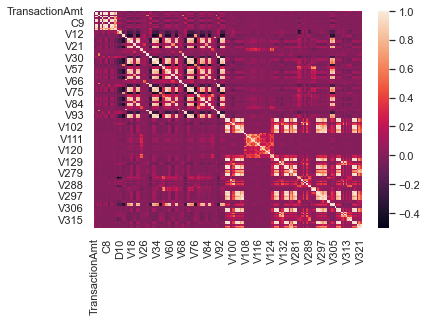

In [13]:
corr = df_drop[numeric_features].corr()
sns.heatmap(df_drop[numeric_features].corr())

In [14]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = df_drop[numeric_features].columns[columns].to_list()
df_drop[selected_columns]

,TransactionAmt,C1,C3,C5,C13,D1,D10,D15,V12,V14,...,V300,V303,V305,V310,V311,V312,V313,V314,V319,V320
0,68.50,1.0,0.0,0.0,1.0,14.0,13.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,29.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,59.00,1.0,0.0,0.0,1.0,0.0,0.0,315.0,1.0,1.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,50.00,2.0,0.0,0.0,25.0,112.0,84.0,111.0,1.0,1.0,...,0.0,0.0,1.0,354.000000,0.0,135.0,0.000000,0.000000,0.000000,0.000000
4,50.00,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.00,2.0,0.0,1.0,3.0,29.0,56.0,56.0,2.0,1.0,...,0.0,0.0,1.0,47.950001,0.0,0.0,47.950001,47.950001,0.000000,0.000000
590536,39.50,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
590537,30.95,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
590538,117.00,1.0,0.0,0.0,5.0,22.0,22.0,22.0,1.0,1.0,...,0.0,0.0,1.0,669.500000,0.0,117.0,317.500000,669.500000,0.000000,0.000000


In [86]:
#df_drop = df_drop[['isFraud']+categorical_features+selected_columns]
df_drop = df_drop.drop(columns=['TransactionID','TransactionDT'])
df_drop.shape

(590540, 180)

## Splitting dataset

In [88]:
train_val_x , test_x , train_val_y , test_y = train_test_split(df_drop.drop(columns=['isFraud']),df_drop['isFraud'],train_size=0.8,stratify=df_drop['isFraud'])

In [17]:
# Change

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampling',RandomUnderSampler()),("classifier",RandomForestClassifier())]
)


In [366]:
# Change

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = OneHotEncoder()

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),("classifier",RandomForestClassifier())]
)

# cross validation
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=3)
scores = cross_val_score(clf,train_val_x,train_val_y,cv=kfold,scoring='precision',n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.18068577 0.17870502 0.17610103 0.17818229 0.17729666]
0.1781941547333577


Text(0, 0.5, 'PCA explained variance ratio')

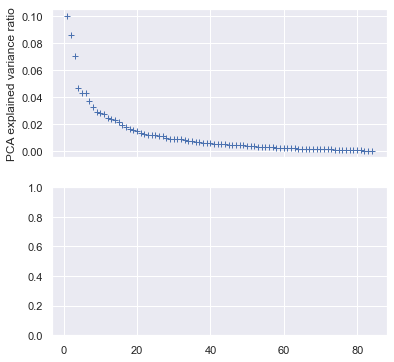

/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [340]:
# PCA
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = OneHotEncoder()

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()),('pca')]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

pca = PCA()
pca.fit(numeric_transformer.fit_transform(train_val_x[numeric_features]))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

In [336]:
# Change
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = OneHotEncoder()

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampling',SMOTE()),("classifier",LogisticRegression())]
)
# cross validation
kfold = StratifiedKFold(n_splits=5,shuffle=True)
scores = cross_val_score(clf,train_val_x,train_val_y,cv=kfold,scoring='roc_auc',n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.82043764 0.82296789 0.8286298  0.82564003 0.82811403]
0.8251578759209046


In [88]:
# grid search
# Change 
# adjust paramaters on your own model
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = OneHotEncoder()

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()),('pca',SparsePCA(n_com))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),("classifier",RandomForestClassifier())]
)

param_grid = {
    "preprocessor__num__pca__n_components" :[10,15,20,25,30,35,40],
    "classifier__n_estimators": [300],
    "classifier__max_features":range(30,60),
    'classifier__max_depth': range(50,80),
}

search = GridSearchCV(clf, param_grid,scoring='roc_auc', n_jobs=-1)
search.fit(train_val_x, train_val_y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

KeyboardInterrupt: 

In [27]:
for c in range(1,10):
    categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

    categorical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')),("onehotcoding", OneHotEncoder())]
    )

    numeric_features = train_val_x.columns.drop(categorical_features)

    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=c)))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features),
             ("num", numeric_transformer, numeric_features),
        ]
    )

    clf = imb_Pipeline(
        steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
    )


    clf.fit(train_val_x,train_val_y)
    print(c)
    print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
    print()

1
0.9122406279854628

2
0.9111166448638273

3
0.9115764761152101

4
0.9117453818253108

5
0.9104845654312599

6
0.9104076344629467

7
0.9119887039549797

8
0.9113262705542998

9
0.9108853498982903



<AxesSubplot:>

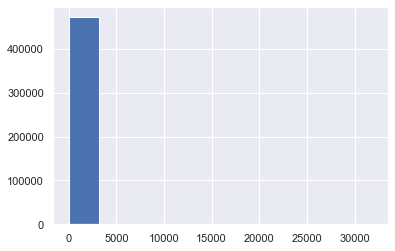

In [54]:
train_val_x['TransactionAmt'].hist()

<AxesSubplot:>

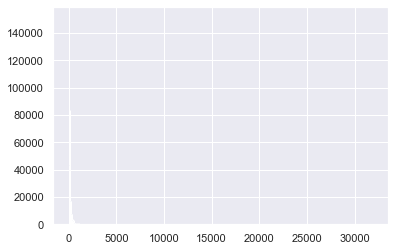

In [60]:
train_val_x['TransactionAmt'].hist(bins=1000)

<AxesSubplot:>

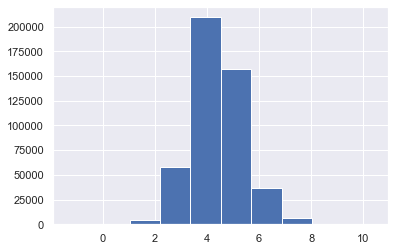

In [53]:
np.log(train_val_x['TransactionAmt']+0.001).hist()

(array([4.72268e+05, 1.63000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([8.51666312e-06, 1.00007665e-01, 2.00006813e-01, 3.00005962e-01,
        4.00005110e-01, 5.00004258e-01, 6.00003407e-01, 7.00002555e-01,
        8.00001703e-01, 9.00000852e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

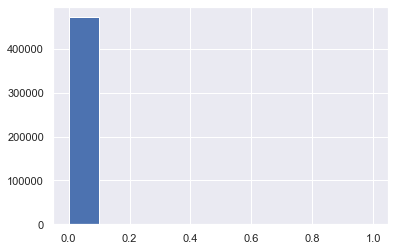

In [44]:
plt.hist(MaxAbsScaler().fit_transform(train_val_x[['TransactionAmt']]))

In [138]:
# final testing
# Change

# Change

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')),("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
         ("num", numeric_transformer, numeric_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))

0.9284328857758537


In [114]:
pca = PCA()
pca.fit(SimpleImputer(strategy='mean').fit_transform(train_val_x[numeric_features]))
pca.explained_variance_ratio_

PCA()

In [119]:
pca.explained_variance_ratio_[0:10].sum()

0.9979052571733068

0.8334004024144869
0.5010887974836681


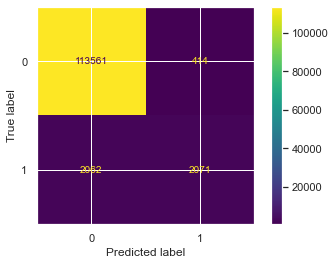

In [37]:
plot_confusion_matrix(clf,test_x,test_y)
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))

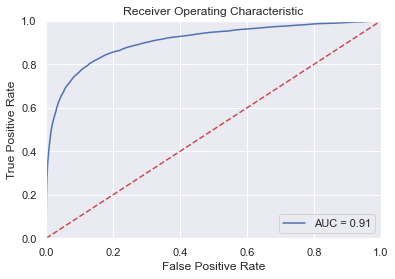

In [139]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [387]:
precision_score(test_y,clf.predict(test_x))

0.3383190883190883

In [388]:
recall_score(test_y,clf.predict(test_x))

0.6895717396564239

In [ ]:
# 그냥 smote썻을때

0.6376429199648197
0.5262521171062182

In [ ]:
# randomforest knn lightbrm

# logisticregression c 

# Neural Network = MLPcalssifier

# svm


In [41]:
a = preprocessor.fit_transform(train_val_x)

array([[-0.48321951,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.12134146,  0.5       ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.05317073,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.15853659,  1.5       ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.36043902,  0.5       ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.47560976,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [65]:
nf = df_transaction.columns.drop(many_null_cols+categorical_features+['TransactionID','isFraud','TransactionDT'])
pca = PCA()
pca.fit_transform(SimpleImputer(strategy='mean').fit_transform(df_transaction[nf]))

array([9.50602417e-01, 2.02169556e-02, 1.15495045e-02, 7.27710977e-03,
       3.32962458e-03, 1.93605511e-03, 1.21990961e-03, 8.04175323e-04,
       5.87219956e-04, 4.42332603e-04, 4.00474780e-04, 3.15039106e-04,
       2.97631697e-04, 1.91543592e-04, 1.63767622e-04, 1.00736562e-04,
       9.59932574e-05, 8.87841245e-05, 7.47046633e-05, 7.09856955e-05,
       6.52895595e-05, 3.70135169e-05, 3.40441959e-05, 2.68626419e-05,
       1.69170857e-05, 1.30851119e-05, 1.27753274e-05, 7.95650581e-06,
       5.89771592e-06, 5.32108006e-06, 3.70996863e-06, 1.56336285e-06,
       1.50888776e-06, 7.95795232e-07, 5.79267265e-07, 4.22422984e-07,
       2.99661486e-07, 2.03540682e-07, 1.44022819e-07, 1.07706486e-07,
       8.23735533e-08, 6.26977916e-08, 5.00271141e-08, 4.77891877e-08,
       4.46581071e-08, 3.18604131e-08, 2.71633200e-08, 2.55349534e-08,
       2.17812288e-08, 2.00383080e-08, 1.60368455e-08, 1.08213324e-08,
       8.95161674e-09, 8.30796496e-09, 8.16147191e-09, 6.26816788e-09,
      

In [72]:
pca.explained_variance_ratio_[0:10].sum()

0.9979653043041155

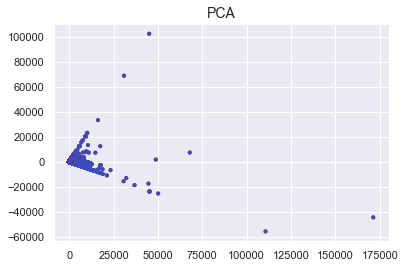

In [66]:
X_reduced_pca =PCA(n_components=2).fit_transform(SimpleImputer(strategy='mean').fit_transform(train_val_x[numeric_features]))
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], s=4, c=(train_val_y == 0),
                cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], s=4, c=(train_val_y == 1),
                cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('PCA', fontsize=14)

plt.show()

In [68]:
from sklearn.manifold import TSNE
X_reduced_tsne = TSNE(n_components=2, random_state=10).fit_transform(SimpleImputer(strategy='mean').fit_transform(train_val_x[numeric_features]))
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 0),
                cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 1),
                cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.show()

NameError: name 'y' is not defined

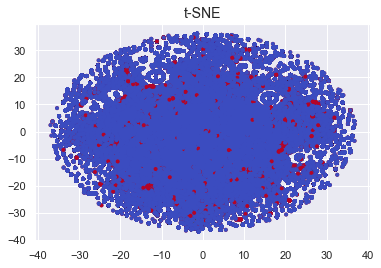

In [69]:
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(train_val_y == 0),
                cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(train_val_y == 1),
                cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.show()

In [70]:
data = RandomUnderSampler().fit_resample(SimpleImputer(strategy='mean').fit_transform(train_val_x[numeric_features]),train_val_y)

(array([[ 49.        ,   2.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 75.        ,   1.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 49.        ,   2.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [139.22      ,  11.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 18.656     ,   2.        ,   0.        , ...,  14.38000011,
           0.        ,   0.        ],
        [ 30.95      ,   3.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]),
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 33055    1
 33056    1
 33057    1
 33058    1
 33059    1
 Name: isFraud, Length: 33060, dtype: int64)

In [76]:
preprocessor.fit_transform(train_val_x)

  (0, 0)	-68.69668742675857
  (0, 1)	-54.68501775424159
  (0, 2)	-6.910011315004844
  (0, 3)	29.397883334238188
  (0, 4)	-6.588322899439483
  (0, 5)	9.948025543015662
  (0, 6)	-7.577128315588838
  (0, 7)	0.2851183671492708
  (0, 8)	2.04429985456034
  (0, 9)	-0.8721917805662938
  (0, 10)	0.0512350102167428
  (0, 11)	-5.338008195976248
  (0, 12)	-0.5978831283246095
  (0, 13)	-0.2277675879032473
  (0, 14)	-1.3328832889950104
  (0, 15)	1.0
  (0, 29)	1.0
  (0, 36)	1.0
  (0, 45)	1.0
  (0, 52)	1.0
  (0, 58)	1.0
  (0, 61)	1.0
  (0, 69)	1.0
  (0, 82)	1.0
  (0, 84)	1.0
  :	:
  (472431, 0)	-68.69718012945472
  (472431, 1)	-54.68432362662798
  (472431, 2)	-6.9078384031858855
  (472431, 3)	29.399772524260573
  (472431, 4)	-6.589601890238929
  (472431, 5)	9.941309757633832
  (472431, 6)	-7.487901359948833
  (472431, 7)	0.28848485944436725
  (472431, 8)	2.0479374786833073
  (472431, 9)	-0.874556852638625
  (472431, 10)	0.04548236715783816
  (472431, 11)	-4.33780124818947
  (472431, 12)	-0.60384606405

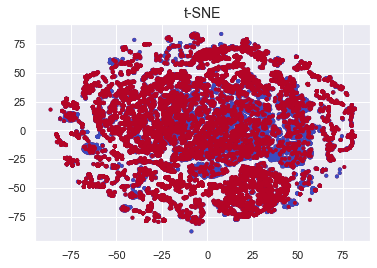

In [73]:
x,y = RandomUnderSampler().fit_resample(SimpleImputer(strategy='median').fit_transform(train_val_x[numeric_features]),train_val_y)
X_reduced_tsne = TSNE(n_components=2, random_state=10).fit_transform(x)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 0),
                cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 1),
                cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.show()

In [80]:
preprocessor.fit_transform((train_val_x)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

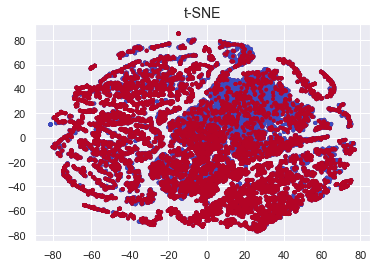

In [82]:
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',RobustScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

x,y = RandomUnderSampler().fit_resample(preprocessor.fit_transform(train_val_x),train_val_y)
X_reduced_tsne = TSNE(n_components=2, random_state=10).fit_transform(x)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 0),
                cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 1),
                cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.show()

In [139]:
# final testing
# Change

# Change
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with pca')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################


categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with selector')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with randomundersampling')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with Random undersampling and PCA')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with Random undersampling and Selector')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE and PCA')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE and Selector')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

Naive RF
0.9119193251244126
0.8535745047372955
0.47955480280667795
Naive RF with pca
0.9238614021915637
0.8846669646848457
0.4788289378175659
Naive RF with selector
0.9230984048855484
0.858324343761237
0.5775465763368014
Naive RF with randomundersampling
0.9166070447593393
0.1704082646269991
0.8301475925477861
Naive RF with SMOTE
0.9009797282684582
0.6581439393939394
0.5044761674328575
Naive RF with Random undersampling and PCA
0.9194165408375083
0.17656265778047056
0.8461166223082507
Naive RF with Random undersampling and Selector
0.9277007232697709
0.201270207852194
0.8434551173481732
Naive RF with SMOTE and PCA
0.9293627943482837
0.5555337904015671
0.6861843697072345
Naive RF with SMOTE and Selector
0.92103526593582
0.6437820669435622
0.6375514154367288


In [140]:
# final testing
# Change

# Change
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with pca')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################


categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with selector')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with randomundersampling')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with Random undersampling and PCA')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################
categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with Random undersampling and Selector')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE and PCA')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',MaxAbsScaler()),('selector',SelectFromModel(LinearSVC(C=0.0026)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',MLPClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE and Selector')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

Naive RF
0.9242858800976332
0.8233305156382079
0.47132833293007503
Naive RF with pca
0.8965911518347476
0.7502558853633572
0.35470602467940965
Naive RF with selector
0.8930958473485284
0.7366175329712956
0.45947253810791194
Naive RF with randomundersampling
0.9108132909345104
0.15690444269797976
0.8211952576820711
Naive RF with SMOTE
0.9218017776660201
0.29062768701633707
0.7360270989595935
Naive RF with Random undersampling and PCA
0.8818491624212206
0.13519646984660644
0.7783692233244617
Naive RF with Random undersampling and Selector
0.8784340666266257
0.15040394755938272
0.7522380837164288
Naive RF with SMOTE and PCA
0.8887902510233996
0.25749625187406294
0.6648923300266151
Naive RF with SMOTE and Selector
0.8976726529874437
0.23228617289612474
0.7353012339704815


In [ ]:
# sparse pca

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',StandardScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with pca')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with randomundersampling')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',StandardScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',RandomUnderSampler()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with Random undersampling and PCA')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

categorical_features = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','addr1','addr2']

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant',fill_value='unknown')), ("onehotcoding", OneHotEncoder())]
)

numeric_features = train_val_x.columns.drop(categorical_features)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),('scaler',StandardScaler()),('pca',PCA(n_components=15))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = imb_Pipeline(
    steps=[("preprocessor", preprocessor),('sampler',SMOTE()),('classifier',RandomForestClassifier(random_state=1))]
)


clf.fit(train_val_x,train_val_y)
print('Naive RF with SMOTE and PCA')
print(roc_auc_score(test_y,clf.predict_proba(test_x)[:, 1]))
print(precision_score(test_y,clf.predict(test_x)))
print(recall_score(test_y,clf.predict(test_x)))
########################################################################

In [176]:
df_drop['V320'].value_counts()

0.000000       542892
117.000000       1298
59.000000        1256
100.000000       1172
57.950001         978
                ...  
10.271400           1
50.614399           1
470.649994          1
2515.889893         1
279.950012          1
Name: V320, Length: 6439, dtype: int64

array([[<AxesSubplot:title={'center':'V15'}>,
        <AxesSubplot:title={'center':'V17'}>,
        <AxesSubplot:title={'center':'V19'}>,
        <AxesSubplot:title={'center':'V23'}>,
        <AxesSubplot:title={'center':'V24'}>],
       [<AxesSubplot:title={'center':'V25'}>,
        <AxesSubplot:title={'center':'V26'}>,
        <AxesSubplot:title={'center':'V27'}>,
        <AxesSubplot:title={'center':'V29'}>,
        <AxesSubplot:title={'center':'V53'}>],
       [<AxesSubplot:title={'center':'V55'}>,
        <AxesSubplot:title={'center':'V56'}>,
        <AxesSubplot:title={'center':'V61'}>,
        <AxesSubplot:title={'center':'V62'}>,
        <AxesSubplot:title={'center':'V65'}>],
       [<AxesSubplot:title={'center':'V66'}>,
        <AxesSubplot:title={'center':'V67'}>,
        <AxesSubplot:title={'center':'V75'}>,
        <AxesSubplot:title={'center':'V77'}>,
        <AxesSubplot:title={'center':'V78'}>],
       [<AxesSubplot:title={'center':'V82'}>,
        <AxesSubplot:title={'c

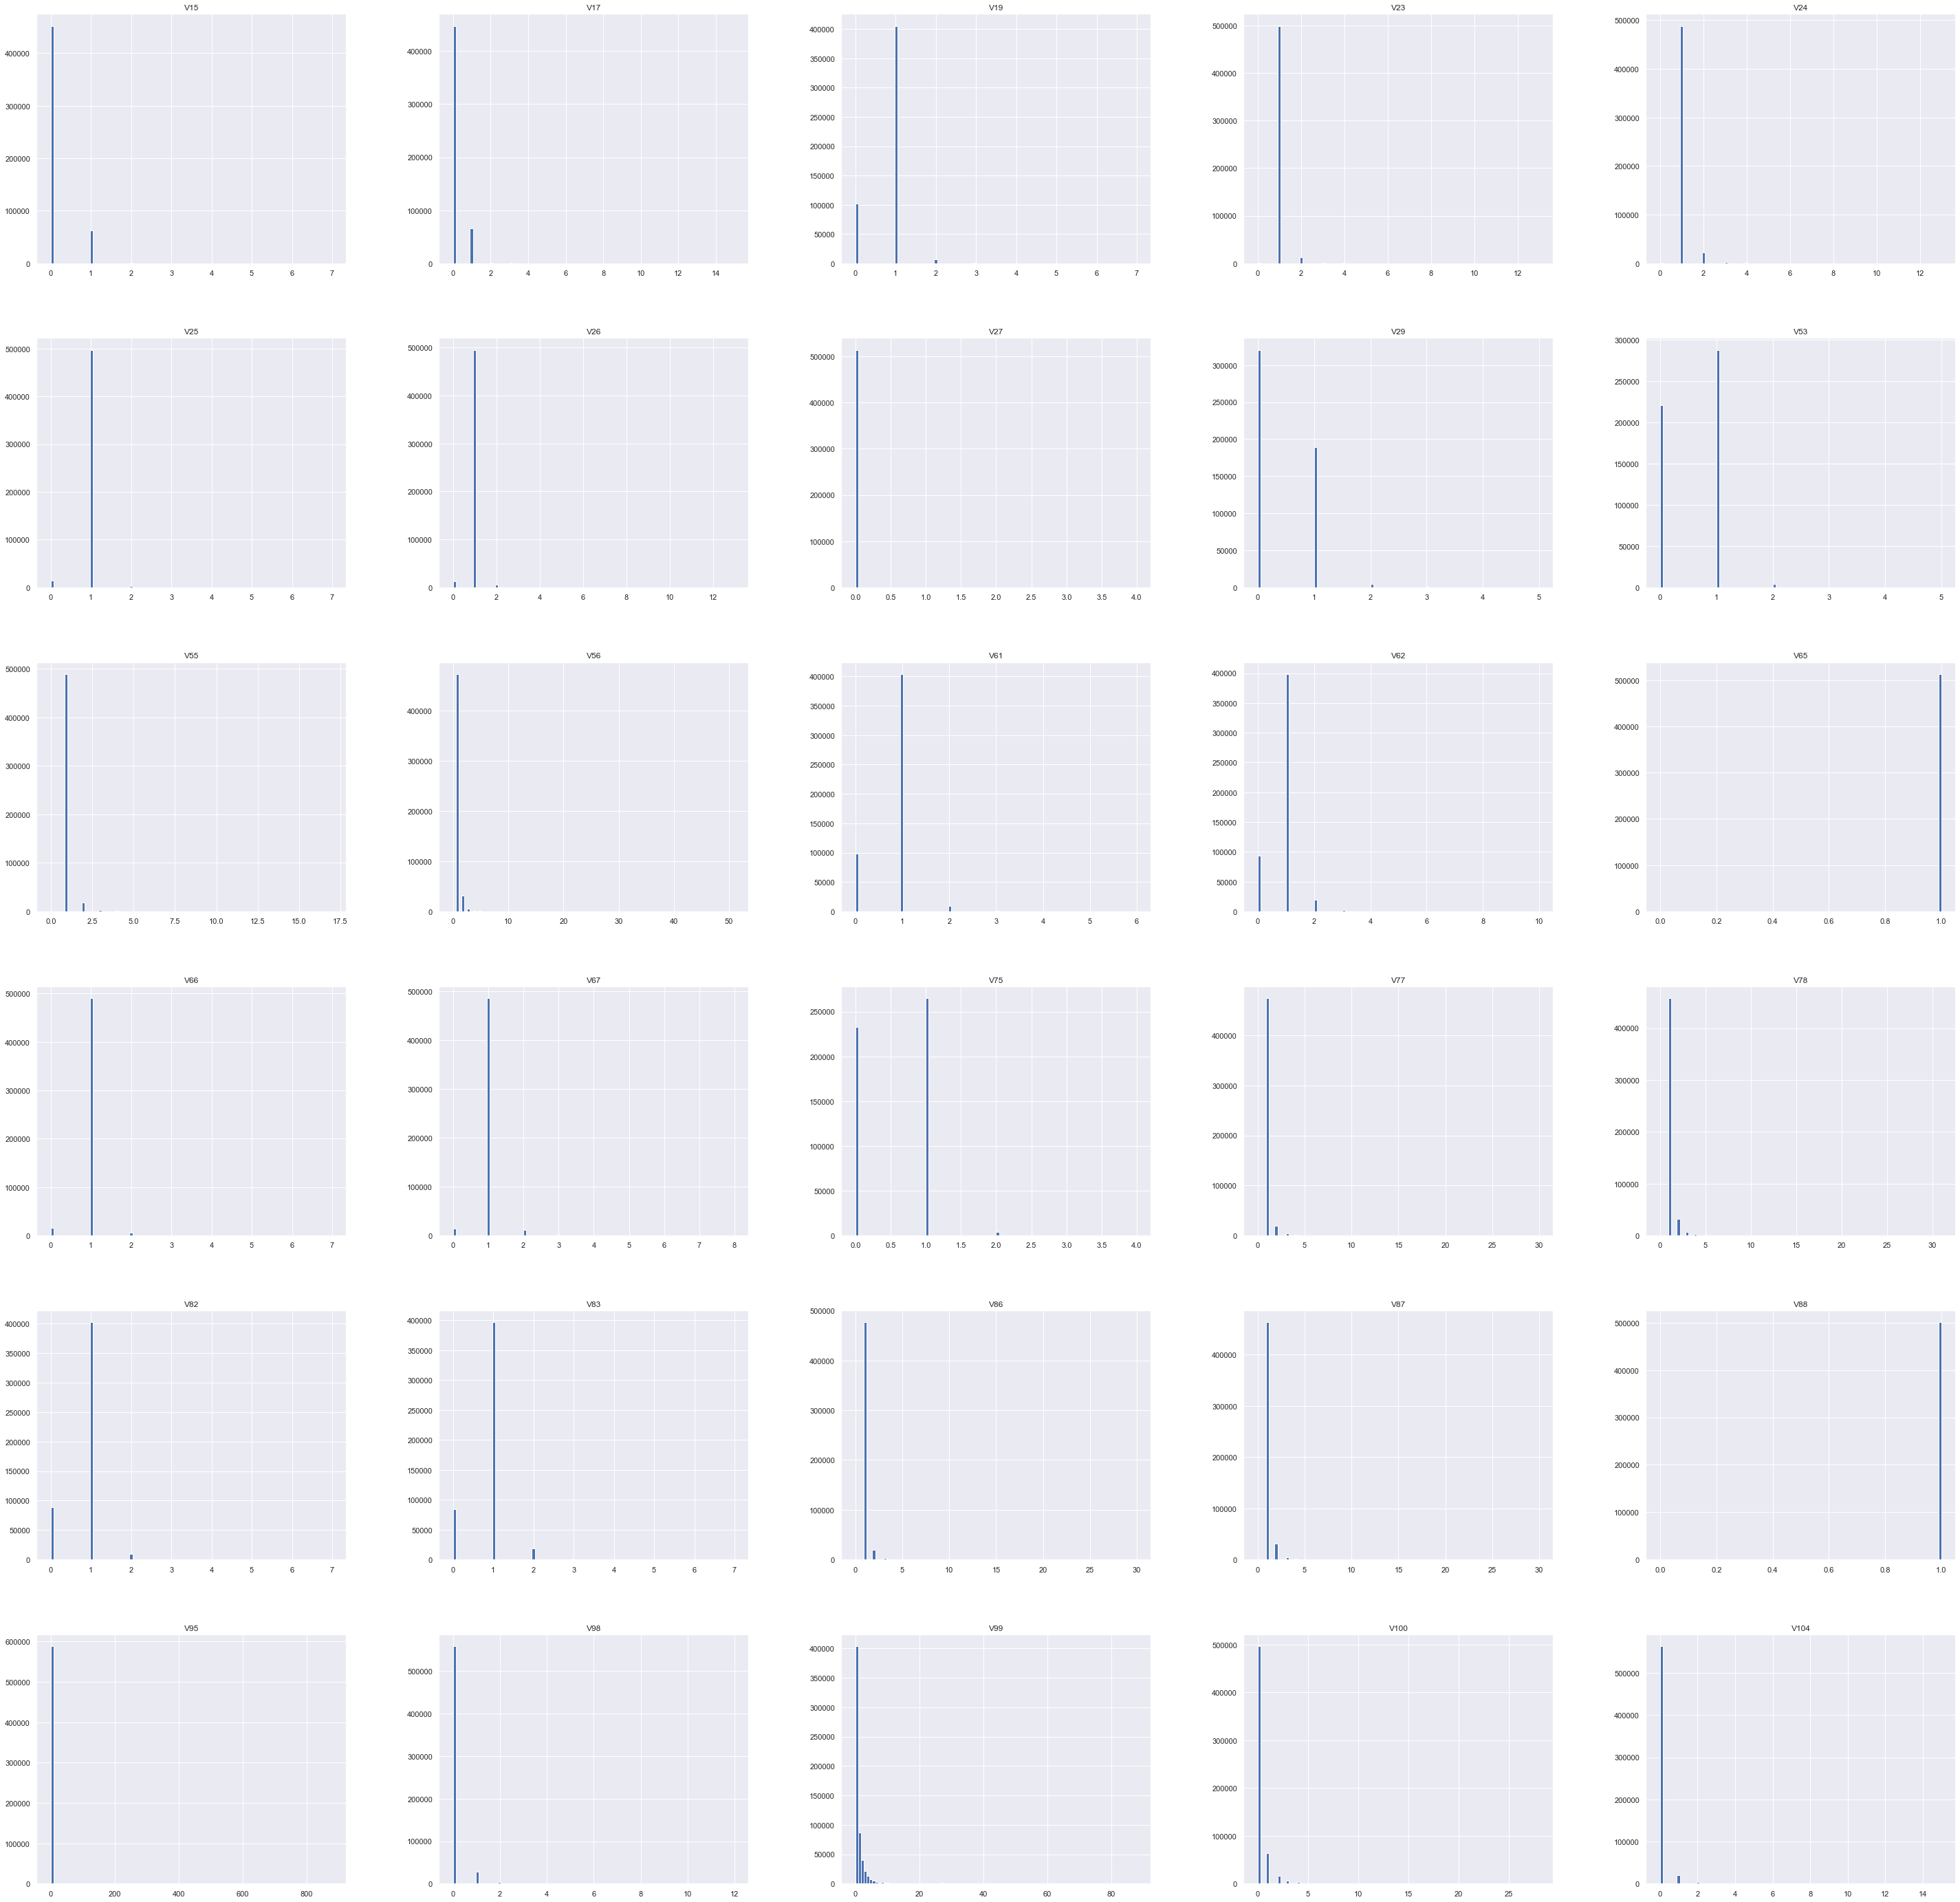

In [181]:
(df_transaction[train_val_x.columns.drop(categorical_features)[10:40]]).hist(figsize=(50,50),bins=100)

In [19]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
